In [ ]:
# Install the Kaggle library
%pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NYCU/Ass3-RNN

/content/drive/MyDrive/NYCU/Ass3-RNN


## 上傳線下編輯好的資料集

## whisper模型微調
這個模型是由國立臺南大學執行國科會產學合作計畫，使用 openai/whisper-large-v3-turbo 微調的版本，並執行國科會TAIDE台英語家庭先導計畫，與真平出版社合作，使用中小學教材內容及學生學習資料進行模型微調，用於真平教材台語辨識。並與國研院國網中心合作，運用國網中心算力以及TAIDE模型，共同建構中小學台語AI學習模型。

```
pip install torch torchvision torchaudio transformers
```



---

## 🎯 RawBoost 資料增強

使用 RawBoost 演算法對訓練資料進行增強，提升模型泛化能力

**RawBoost 演算法說明：**
- **Algorithm 1 (LnL)**: 線性/非線性卷積噪音
- **Algorithm 2 (ISD)**: 脈衝訊號相依噪音
- **Algorithm 3 (SSI)**: 平穩訊號獨立噪音 ✅ **推薦用於語音辨識**
- **Algorithm 6 (1+3)**: 結合 LnL 和 SSI ✅ **推薦用於語音辨識**

**建議設定：**
- 對於台語語音辨識，建議使用 **Algorithm 3 (SSI)** 或 **Algorithm 6 (1+3)**
- 這些演算法會添加自然的背景噪音，模擬真實環境

In [ ]:
# 🎯 RawBoost 資料增強 - 使用腳本版本

# 方法 1: 使用命令列執行
# !python data_augmentation_rawboost.py \
#     --input_dir "./train/preprocessed" \
#     --output_dir "./train/rawboost_augmented" \
#     --csv_input "./train/trainAgg-toneless.csv" \
#     --csv_output "./train/trainAgg-toneless-rawboost.csv" \
#     --algo_types 3 6 \
#     --num_aug 1

# 方法 2: 直接在 Notebook 中執行 (推薦)
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import librosa
from tqdm import tqdm
from RawBoost import ISD_additive_noise, LnL_convolutive_noise, SSI_additive_noise, normWav

# RawBoost 參數設定
class RawBoostConfig:
    def __init__(self):
        # Algorithm 1: LnL
        self.N_f = 5
        self.nBands = 5
        self.minF = 20
        self.maxF = 8000
        self.minBW = 100
        self.maxBW = 1000
        self.minCoeff = 10
        self.maxCoeff = 100
        self.minG = 0
        self.maxG = 0
        self.minBiasLinNonLin = 5
        self.maxBiasLinNonLin = 20

        # Algorithm 2: ISD
        self.P = 10
        self.g_sd = 2

        # Algorithm 3: SSI
        self.SNRmin = 10
        self.SNRmax = 40

def apply_rawboost(audio, sr, args, algo_type):
    """應用 RawBoost 增強"""
    if algo_type == 1:
        return LnL_convolutive_noise(
            audio, args.N_f, args.nBands, args.minF, args.maxF,
            args.minBW, args.maxBW, args.minCoeff, args.maxCoeff,
            args.minG, args.maxG, args.minBiasLinNonLin, args.maxBiasLinNonLin, sr
        )
    elif algo_type == 2:
        return ISD_additive_noise(audio, args.P, args.g_sd)
    elif algo_type == 3:
        return SSI_additive_noise(
            audio, args.SNRmin, args.SNRmax, args.nBands, args.minF, args.maxF,
            args.minBW, args.maxBW, args.minCoeff, args.maxCoeff,
            args.minG, args.maxG, sr
        )
    elif algo_type == 6:  # 1+3
        audio = LnL_convolutive_noise(
            audio, args.N_f, args.nBands, args.minF, args.maxF,
            args.minBW, args.maxBW, args.minCoeff, args.maxCoeff,
            args.minG, args.maxG, args.minBiasLinNonLin, args.maxBiasLinNonLin, sr
        )
        return SSI_additive_noise(
            audio, args.SNRmin, args.SNRmax, args.nBands, args.minF, args.maxF,
            args.minBW, args.maxBW, args.minCoeff, args.maxCoeff,
            args.minG, args.maxG, sr
        )
    return audio

def normalize_audio(audio):
    """正規化音訊"""
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))
    return audio

def audio_to_int16(audio):
    """轉換為 int16"""
    audio = normalize_audio(audio)
    return (audio * 32767).astype(np.int16)

# ==================== 執行增強 ====================

# 設定路徑
input_dir = "./train/preprocessed"
# input_dir = "./train/train/train"
output_dir = "./train/rawboost_augmentedV2"
csv_input = "./train/train/trainAgg-toneless.csv"
csv_output = "./train/train/trainAgg-toneless-rawboost.csv"

# 設定參數
algo_types = [3, 6]  # 使用 SSI 和 LnL+SSI
target_sr = 16000

# 建立輸出目錄
os.makedirs(output_dir, exist_ok=True)

# 載入 CSV
df = pd.read_csv(csv_input)
print(f"📊 讀取 {csv_input}，共 {len(df)} 筆資料\n")

# 初始化參數
rawboost_args = RawBoostConfig()
new_rows = []

# 取得音訊檔案
audio_files = [f for f in os.listdir(input_dir) if f.endswith('.wav')]

print(f"🎵 開始處理 {len(audio_files)} 個音訊檔案...")
print(f"📌 使用演算法: {algo_types}\n")

# 處理每個檔案
for file in tqdm(audio_files, desc="RawBoost 增強"):
    try:
        # 載入音訊
        audio_path = os.path.join(input_dir, file)
        audio, sr = librosa.load(audio_path, sr=target_sr)

        file_id = file.replace('.wav', '')

        # ✅ 檢查 file_id 是否為純數字
        if not file_id.isdigit():
            print(f"\n⚠️ 跳過非數字檔名: {file}")
            continue

        # 儲存原始檔案 (標準化)
        audio_normalized = audio_to_int16(audio)
        wavfile.write(os.path.join(output_dir, file), target_sr, audio_normalized)

        # 對每種演算法生成增強版本
        for algo_type in algo_types:
            # 應用 RawBoost
            augmented_audio = apply_rawboost(audio.copy(), sr, rawboost_args, algo_type)
            augmented_audio_int16 = audio_to_int16(augmented_audio)

            # 生成新檔名
            aug_filename = f"{file_id}_rawboost_algo{algo_type}.wav"

            # 儲存
            wavfile.write(
                os.path.join(output_dir, aug_filename),
                target_sr,
                augmented_audio_int16
            )

            # 更新 CSV
            original_row = df.loc[df['id'] == int(file_id)].iloc[0].copy()
            original_row['id'] = aug_filename.replace('.wav', '')
            new_rows.append(original_row)

    except Exception as e:
        print(f"\n❌ 處理失敗 {file}: {e}")

print(f"\n✅ 音訊處理完成！")
print(f"   原始檔案: {len(audio_files)}")
print(f"   增強檔案: {len(new_rows)}")
print(f"   總計: {len(audio_files) + len(new_rows)}")

# 合併並儲存 CSV
df_augmented = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
df_augmented.to_csv(csv_output, index=False)

print(f"\n✅ CSV 檔案已更新: {csv_output}")
print(f"   總筆數: {len(df_augmented)}")

# 資料加強V2
混和舊方法+Rawboost 3&6

In [ ]:
# ==================== 資料加強V2: 混合舊方法 + RawBoost ====================

import os
import pandas as pd
import librosa
from scipy.io import wavfile
from tqdm import tqdm
import shutil

# 設定路徑
input_Old_dir = "./train/preprocessed"
input_RawBoost_dir = "./train/rawboost_augmentedV1"
output_dir = "./train/rawboost_augmentedV2"

csv_Old_input = "./train/train/trainAgg-toneless.csv"
csv_RawBoost_input = "./train/train/train-toneless-rawboost.csv"
csv_output = "./train/train/trainAgg-toneless-rawboost.csv"

# 設定參數
target_sr = 16000

# ✅ 清空並重建輸出目錄
if os.path.exists(output_dir):
    print(f"⚠️ 輸出目錄已存在，刪除舊資料...")
    shutil.rmtree(output_dir)

os.makedirs(output_dir, exist_ok=True)
print(f"✅ 已建立輸出目錄: {output_dir}\n")

# ==================== 載入 CSV ====================

df_old = pd.read_csv(csv_Old_input)
print(f"📊 讀取舊方法 CSV: {csv_Old_input}")
print(f"   筆數: {len(df_old)}\n")

df_RawBoost = pd.read_csv(csv_RawBoost_input)
print(f"📊 讀取 RawBoost CSV: {csv_RawBoost_input}")
print(f"   筆數: {len(df_RawBoost)}\n")

# ✅ 轉換 ID 為字串
df_old['id'] = df_old['id'].astype(str)
df_RawBoost['id'] = df_RawBoost['id'].astype(str)

# ==================== 複製舊方法的音訊檔案 ====================

print("📁 步驟 1: 複製舊方法的音訊檔案...")

# 取得舊方法的增強檔案
audio_old_files = [
    f for f in os.listdir(input_Old_dir)
    if f.endswith('.wav') and f.replace('.wav', '')
]

print(f"   找到 {len(audio_old_files)} 個舊方法音訊檔案")

copied_old = 0
for file in tqdm(audio_old_files, desc="複製舊方法音訊"):
    try:
        src_path = os.path.join(input_Old_dir, file)
        dst_path = os.path.join(output_dir, file)

        # ✅ 直接複製檔案（更快）
        shutil.copy2(src_path, dst_path)
        copied_old += 1

    except Exception as e:
        print(f"\n❌ 複製失敗 {file}: {e}")

print(f"✅ 已複製 {copied_old} 個舊方法音訊檔案\n")

# ==================== 複製 RawBoost 增強檔案 ====================

print("📁 步驟 2: 複製 RawBoost 增強檔案...")

# ✅ 只取得增強過的檔案（檔名包含 _algo）
audio_RawBoost_files = [
    f for f in os.listdir(input_RawBoost_dir)
    if f.endswith('.wav') and ('_algo3' in f or '_algo6' in f)
]

print(f"   找到 {len(audio_RawBoost_files)} 個 RawBoost 增強檔案")

copied_rawboost = 0
rawboost_rows = []

for file in tqdm(audio_RawBoost_files, desc="複製 RawBoost 音訊"):
    try:
        file_id = file.replace('.wav', '')

        # 複製音訊檔案
        src_path = os.path.join(input_RawBoost_dir, file)
        dst_path = os.path.join(output_dir, file)
        shutil.copy2(src_path, dst_path)

        # ✅ 查找對應的 CSV row
        matching_rows = df_RawBoost[df_RawBoost['id'] == file_id]

        if len(matching_rows) > 0:
            row = matching_rows.iloc[0].copy()
            rawboost_rows.append(row)
            copied_rawboost += 1
        else:
            print(f"\n⚠️ CSV 中找不到 {file_id}")

    except Exception as e:
        print(f"\n❌ 複製失敗 {file}: {e}")

print(f"✅ 已複製 {copied_rawboost} 個 RawBoost 增強檔案\n")

# ==================== 合併 CSV ====================

print("📊 步驟 3: 合併 CSV...")

# ✅ 合併所有 DataFrame
if len(rawboost_rows) > 0:
    df_rawboost_new = pd.DataFrame(rawboost_rows)
    df_augmented = pd.concat([df_old, df_rawboost_new], ignore_index=True)
else:
    print("⚠️ 沒有 RawBoost 資料，只使用舊方法")
    df_augmented = df_old.copy()

# 儲存合併後的 CSV
df_augmented.to_csv(csv_output, index=False)

# ==================== 統計結果 ====================

print(f"\n{'='*60}")
print(f"✅ 合併完成！")
print(f"{'='*60}")
print(f"📊 CSV 統計:")
print(f"   舊方法資料: {len(df_old)} 筆")
print(f"   RawBoost 增強: {len(rawboost_rows)} 筆")
print(f"   合併後總計: {len(df_augmented)} 筆")
print(f"\n📁 音訊檔案統計:")
print(f"   舊方法音訊: {copied_old} 個")
print(f"   RawBoost 音訊: {copied_rawboost} 個")
print(f"   總計: {len(os.listdir(output_dir))} 個")
print(f"\n💾 輸出位置:")
print(f"   音訊目錄: {output_dir}")
print(f"   CSV 檔案: {csv_output}")
print(f"{'='*60}")

# ==================== 驗證結果 ====================

print(f"\n🔍 驗證 CSV 和音訊檔案是否匹配...")

# 取得所有音訊檔案的 ID
audio_ids = set([f.replace('.wav', '') for f in os.listdir(output_dir) if f.endswith('.wav')])

# 取得 CSV 中的 ID
csv_ids = set(df_augmented['id'].astype(str))

# 找出不匹配的
audio_not_in_csv = audio_ids - csv_ids
csv_not_in_audio = csv_ids - audio_ids

if len(audio_not_in_csv) > 0:
    print(f"⚠️ 有音訊但 CSV 中沒有: {len(audio_not_in_csv)} 個")
    print(f"   前 10 個: {list(audio_not_in_csv)[:10]}")

if len(csv_not_in_audio) > 0:
    print(f"⚠️ CSV 中有但沒音訊: {len(csv_not_in_audio)} 個")
    print(f"   前 10 個: {list(csv_not_in_audio)[:10]}")

if len(audio_not_in_csv) == 0 and len(csv_not_in_audio) == 0:
    print(f"✅ 完美匹配！CSV 和音訊檔案完全一致")

⚠️ 輸出目錄已存在，刪除舊資料...
✅ 已建立輸出目錄: ./train/rawboost_augmentedV2

📊 讀取舊方法 CSV: ./train/train/trainAgg-toneless.csv
   筆數: 6238

📊 讀取 RawBoost CSV: ./train/train/train-toneless-rawboost.csv
   筆數: 9357

📁 步驟 1: 複製舊方法的音訊檔案...
   找到 6238 個舊方法音訊檔案


複製舊方法音訊: 100%|██████████| 6238/6238 [03:06<00:00, 33.42it/s]


✅ 已複製 6238 個舊方法音訊檔案

📁 步驟 2: 複製 RawBoost 增強檔案...
   找到 6238 個 RawBoost 增強檔案


複製 RawBoost 音訊: 100%|██████████| 6238/6238 [11:25<00:00,  9.10it/s]


✅ 已複製 6238 個 RawBoost 增強檔案

📊 步驟 3: 合併 CSV...

✅ 合併完成！
📊 CSV 統計:
   舊方法資料: 6238 筆
   RawBoost 增強: 6238 筆
   合併後總計: 12476 筆

📁 音訊檔案統計:
   舊方法音訊: 6238 個
   RawBoost 音訊: 6238 個
   總計: 12476 個

💾 輸出位置:
   音訊目錄: ./train/rawboost_augmentedV2
   CSV 檔案: ./train/train/trainAgg-toneless-rawboost.csv

🔍 驗證 CSV 和音訊檔案是否匹配...
✅ 完美匹配！CSV 和音訊檔案完全一致


多執行緒加速版

In [ ]:
# ==================== 資料加強V2: 混合舊方法 + RawBoost (多執行緒加速版) ====================

import os
import pandas as pd
import shutil
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock

# 設定路徑
input_Old_dir = "./train/preprocessed"
input_RawBoost_dir = "./train/rawboost_augmentedV1"
output_dir = "./train/rawboost_augmentedV2"

csv_Old_input = "./train/train/trainAgg-toneless.csv"
csv_RawBoost_input = "./train/train/train-toneless-rawboost.csv"
csv_output = "./train/train/trainAgg-toneless-rawboost.csv"

# ✅ 多執行緒設定
NUM_WORKERS = 8  # Colab 建議 4-8，本地可用 8-16

# ✅ 清空並重建輸出目錄
if os.path.exists(output_dir):
    print(f"⚠️ 輸出目錄已存在，刪除舊資料...")
    shutil.rmtree(output_dir)

os.makedirs(output_dir, exist_ok=True)
print(f"✅ 已建立輸出目錄: {output_dir}\n")

# ==================== 載入 CSV ====================

df_old = pd.read_csv(csv_Old_input)
print(f"📊 讀取舊方法 CSV: {csv_Old_input}")
print(f"   筆數: {len(df_old)}\n")

df_RawBoost = pd.read_csv(csv_RawBoost_input)
print(f"📊 讀取 RawBoost CSV: {csv_RawBoost_input}")
print(f"   筆數: {len(df_RawBoost)}\n")

# ✅ 轉換 ID 為字串
df_old['id'] = df_old['id'].astype(str)
df_RawBoost['id'] = df_RawBoost['id'].astype(str)

# ==================== 定義複製函數 ====================

def copy_single_file(file, src_dir, dst_dir):
    """複製單個檔案（用於多執行緒）"""
    try:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, file)
        shutil.copy2(src_path, dst_path)
        return (True, file, None)
    except Exception as e:
        return (False, file, str(e))

def copy_rawboost_file(file, src_dir, dst_dir, df_RawBoost):
    """複製 RawBoost 檔案並取得 CSV row"""
    try:
        file_id = file.replace('.wav', '')

        # 複製檔案
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, file)
        shutil.copy2(src_path, dst_path)

        # 查找 CSV row
        matching_rows = df_RawBoost[df_RawBoost['id'] == file_id]

        if len(matching_rows) > 0:
            row = matching_rows.iloc[0].copy()
            return (True, file, row)
        else:
            return (True, file, None)
    except Exception as e:
        return (False, file, str(e))

# ==================== 步驟 1: 複製舊方法音訊（多執行緒） ====================

print("📁 步驟 1: 複製舊方法的音訊檔案...")

audio_old_files = [
    f for f in os.listdir(input_Old_dir)
    if f.endswith('.wav')
]

print(f"   找到 {len(audio_old_files)} 個舊方法音訊檔案")
print(f"   使用 {NUM_WORKERS} 個執行緒加速...\n")

copied_old = 0
failed_old = 0

# ✅ 使用 ThreadPoolExecutor 並行複製
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    # 提交所有任務
    futures = {
        executor.submit(copy_single_file, file, input_Old_dir, output_dir): file
        for file in audio_old_files
    }

    # 使用 tqdm 顯示進度
    with tqdm(total=len(audio_old_files), desc="複製舊方法音訊") as pbar:
        for future in as_completed(futures):
            success, file, error = future.result()
            if success:
                copied_old += 1
            else:
                failed_old += 1
                print(f"\n❌ 複製失敗 {file}: {error}")
            pbar.update(1)

print(f"✅ 已複製 {copied_old} 個舊方法音訊檔案")
if failed_old > 0:
    print(f"⚠️ 失敗 {failed_old} 個\n")
else:
    print()

# ==================== 步驟 2: 複製 RawBoost 增強檔案（多執行緒） ====================

print("📁 步驟 2: 複製 RawBoost 增強檔案...")

# ✅ 只取得增強過的檔案（檔名包含 _algo）
audio_RawBoost_files = [
    f for f in os.listdir(input_RawBoost_dir)
    if f.endswith('.wav') and ('_algo3' in f or '_algo6' in f)
]

print(f"   找到 {len(audio_RawBoost_files)} 個 RawBoost 增強檔案")
print(f"   使用 {NUM_WORKERS} 個執行緒加速...\n")

copied_rawboost = 0
failed_rawboost = 0
rawboost_rows = []

# ✅ 使用 Lock 保護 list（多執行緒安全）
rows_lock = Lock()

# ✅ 使用 ThreadPoolExecutor 並行複製
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    # 提交所有任務
    futures = {
        executor.submit(copy_rawboost_file, file, input_RawBoost_dir, output_dir, df_RawBoost): file
        for file in audio_RawBoost_files
    }

    # 使用 tqdm 顯示進度
    with tqdm(total=len(audio_RawBoost_files), desc="複製 RawBoost 音訊") as pbar:
        for future in as_completed(futures):
            success, file, result = future.result()
            if success:
                copied_rawboost += 1
                if result is not None:
                    # ✅ 使用 Lock 保護 list append
                    with rows_lock:
                        rawboost_rows.append(result)
                else:
                    print(f"\n⚠️ CSV 中找不到 {file.replace('.wav', '')}")
            else:
                failed_rawboost += 1
                print(f"\n❌ 複製失敗 {file}: {result}")
            pbar.update(1)

print(f"✅ 已複製 {copied_rawboost} 個 RawBoost 增強檔案")
if failed_rawboost > 0:
    print(f"⚠️ 失敗 {failed_rawboost} 個\n")
else:
    print()

# ==================== 步驟 3: 合併 CSV ====================

print("📊 步驟 3: 合併 CSV...")

# ✅ 合併所有 DataFrame
if len(rawboost_rows) > 0:
    df_rawboost_new = pd.DataFrame(rawboost_rows)
    df_augmented = pd.concat([df_old, df_rawboost_new], ignore_index=True)
else:
    print("⚠️ 沒有 RawBoost 資料，只使用舊方法")
    df_augmented = df_old.copy()

# 儲存合併後的 CSV
df_augmented.to_csv(csv_output, index=False)

# ==================== 統計結果 ====================

print(f"\n{'='*60}")
print(f"✅ 合併完成！")
print(f"{'='*60}")
print(f"📊 CSV 統計:")
print(f"   舊方法資料: {len(df_old)} 筆")
print(f"   RawBoost 增強: {len(rawboost_rows)} 筆")
print(f"   合併後總計: {len(df_augmented)} 筆")
print(f"\n📁 音訊檔案統計:")
print(f"   舊方法音訊: {copied_old} 個")
print(f"   RawBoost 音訊: {copied_rawboost} 個")
print(f"   總計: {len(os.listdir(output_dir))} 個")
print(f"\n💾 輸出位置:")
print(f"   音訊目錄: {output_dir}")
print(f"   CSV 檔案: {csv_output}")
print(f"{'='*60}")

# ==================== 驗證結果 ====================

print(f"\n🔍 驗證 CSV 和音訊檔案是否匹配...")

# 取得所有音訊檔案的 ID
audio_ids = set([f.replace('.wav', '') for f in os.listdir(output_dir) if f.endswith('.wav')])

# 取得 CSV 中的 ID
csv_ids = set(df_augmented['id'].astype(str))

# 找出不匹配的
audio_not_in_csv = audio_ids - csv_ids
csv_not_in_audio = csv_ids - audio_ids

if len(audio_not_in_csv) > 0:
    print(f"⚠️ 有音訊但 CSV 中沒有: {len(audio_not_in_csv)} 個")
    print(f"   前 10 個: {list(audio_not_in_csv)[:10]}")

if len(csv_not_in_audio) > 0:
    print(f"⚠️ CSV 中有但沒音訊: {len(csv_not_in_audio)} 個")
    print(f"   前 10 個: {list(csv_not_in_audio)[:10]}")

if len(audio_not_in_csv) == 0 and len(csv_not_in_audio) == 0:
    print(f"✅ 完美匹配！CSV 和音訊檔案完全一致")

print(f"\n⚡ 使用了 {NUM_WORKERS} 個執行緒，大幅加速複製過程！")

⚠️ 輸出目錄已存在，刪除舊資料...
✅ 已建立輸出目錄: ./train/rawboost_augmentedV2

📊 讀取舊方法 CSV: ./train/train/trainAgg-toneless.csv
   筆數: 6238

📊 讀取 RawBoost CSV: ./train/train/train-toneless-rawboost.csv
   筆數: 9357

📁 步驟 1: 複製舊方法的音訊檔案...
   找到 6238 個舊方法音訊檔案
   使用 8 個執行緒加速...



複製舊方法音訊: 100%|██████████| 6238/6238 [03:57<00:00, 26.32it/s]


✅ 已複製 6238 個舊方法音訊檔案

📁 步驟 2: 複製 RawBoost 增強檔案...
   找到 6238 個 RawBoost 增強檔案
   使用 8 個執行緒加速...



複製 RawBoost 音訊: 100%|██████████| 6238/6238 [11:19<00:00,  9.18it/s]


✅ 已複製 6238 個 RawBoost 增強檔案

📊 步驟 3: 合併 CSV...

✅ 合併完成！
📊 CSV 統計:
   舊方法資料: 6238 筆
   RawBoost 增強: 6238 筆
   合併後總計: 12476 筆

📁 音訊檔案統計:
   舊方法音訊: 6238 個
   RawBoost 音訊: 6238 個
   總計: 12476 個

💾 輸出位置:
   音訊目錄: ./train/rawboost_augmentedV2
   CSV 檔案: ./train/train/trainAgg-toneless-rawboost.csv

🔍 驗證 CSV 和音訊檔案是否匹配...
✅ 完美匹配！CSV 和音訊檔案完全一致

⚡ 使用了 8 個執行緒，大幅加速複製過程！


---

## 📊 更新訓練配置 - 針對比賽優化

根據比賽評分標準 (Mean Levenshtein Distance) 和訓練穩定性進行優化

In [ ]:
# 安裝所需套件
%pip install pandas numpy seaborn transformers datasets
%pip install scikit-learn librosa soundfile jiwer
%pip install accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# 1️⃣ 載入資料
import pandas as pd
from sklearn.model_selection import train_test_split

train_dir = "./train/rawboost_augmentedV2"
train_csv = "./train/train/trainAgg-toneless-rawboost.csv"

# 讀取 CSV 並分割訓練/驗證資料
df = pd.read_csv(train_csv)
print(f"📊 總資料筆數: {len(df)}")

# 分割訓練和驗證資料 (90% 訓練, 10% 驗證)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

print(f"✅ 訓練集: {len(train_df)} 筆")
print(f"✅ 驗證集: {len(val_df)} 筆")

# 儲存分割後的 CSV (可選)
train_df.to_csv("./train/train_split.csv", index=False)
val_df.to_csv("./train/val_split.csv", index=False)

📊 總資料筆數: 12476
✅ 訓練集: 11228 筆
✅ 驗證集: 1248 筆


In [ ]:
# 2️⃣ 建立 PyTorch Dataset
import torch
from torch.utils.data import Dataset
import librosa
import os

class TaiwaneseAudioDataset(Dataset):
    """台語音訊資料集"""

    def __init__(self, dataframe, audio_dir, processor, max_length=40):
        """
        Args:
            dataframe: 包含 'id' 和 'text' 欄位的 DataFrame
            audio_dir: 音訊檔案所在目錄
            processor: Whisper processor
            max_length: 最大音訊長度（秒）
        """
        self.df = dataframe.reset_index(drop=True)
        self.audio_dir = audio_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 取得資料
        row = self.df.iloc[idx]
        audio_id = str(row['id'])
        text = row['text']

        # 音訊檔案路徑 (處理 augmented 檔案)
        if 'augmented' in audio_id:
            audio_path = os.path.join(self.audio_dir, f"{audio_id}.wav")
        else:
            audio_path = os.path.join(self.audio_dir, f"{audio_id}.wav")

        # 載入音訊 (16kHz)
        try:
            audio, sr = librosa.load(audio_path, sr=16000)

            # 限制長度
            max_samples = int(self.max_length * sr)
            if len(audio) > max_samples:
                audio = audio[:max_samples]

            # 使用 processor 處理音訊
            inputs = self.processor(
                audio,
                sampling_rate=16000,
                return_tensors="pt",
                padding="longest"
            )

            # 處理文字標籤
            labels = self.processor.tokenizer(
                text,
                return_tensors="pt",
                padding="longest"
            )

            return {
                "input_features": inputs.input_features.squeeze(0),
                "labels": labels.input_ids.squeeze(0)
            }

        except Exception as e:
            print(f"❌ 載入失敗 {audio_path}: {e}")
            # 回傳空資料
            return {
                "input_features": torch.zeros(80, 3000),  # Whisper 預設特徵維度
                "labels": torch.zeros(1, dtype=torch.long)
            }

print("✅ Dataset 類別定義完成")

✅ Dataset 類別定義完成


台南大學台語模型

In [ ]:
# 3️⃣ 載入模型和 Processor
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
import torch
import gc

print("🧹 清除 GPU 記憶體...")

# 1. 清除所有 CUDA 快取
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    # 2. 強制 Python 垃圾回收
    gc.collect()

    # 3. 顯示記憶體狀態
    print(f"✅ GPU 記憶體已清除")
    print(f"   已分配: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"   已保留: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

    # 4. 重置記憶體統計（可選）
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()

else:
    print("⚠️ 沒有可用的 GPU")

# 檢查 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ 使用裝置: {device}")

# 載入 processor 和模型
# model_name = "NUTN-KWS/Whisper-Taiwanese-model-v0.5"
# model_name = "simonl0909/whisper-large-v2-cantonese"
model_name = "JacobLinCool/whisper-large-v3-turbo-common_voice_19_0-zh-TW"


print(f"📥 載入 Processor 和模型: {model_name}")
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name)

# 移至 GPU
model = model.to(device)

print(f"✅ 模型已載入")
print(f"   參數量: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")
print(f"   可訓練參數: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.1f}M")

🧹 清除 GPU 記憶體...
✅ GPU 記憶體已清除
   已分配: 3.08 GB
   已保留: 3.17 GB
🖥️ 使用裝置: cuda
📥 載入 Processor 和模型: JacobLinCool/whisper-large-v3-turbo-common_voice_19_0-zh-TW
✅ 模型已載入
   參數量: 808.9M
   可訓練參數: 807.0M


In [ ]:
# 4️⃣ 建立 DataLoader
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

# 建立訓練和驗證資料集
train_dataset = TaiwaneseAudioDataset(train_df, train_dir, processor, max_length=30)
val_dataset = TaiwaneseAudioDataset(val_df, train_dir, processor, max_length=30)

print(f"✅ 訓練集大小: {len(train_dataset)}")
print(f"✅ 驗證集大小: {len(val_dataset)}")

# 自定義 Data Collator
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    自定義 Data Collator,用於處理語音轉文字任務的批次資料
    """
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 分離音訊特徵和標籤
        input_features = [feature["input_features"] for feature in features]
        label_features = [feature["labels"] for feature in features]

        # ✅ Whisper 要求固定長度
        batch_size = len(input_features)
        feature_dim = 128      # Whisper 固定使用 128 個 Mel bins，廣東使用80
        max_length = 3000     # Whisper 固定時間步長

        # 建立固定大小的 tensor (初始化為 0)
        input_features_padded = torch.zeros(batch_size, feature_dim, max_length)

        # 處理每個音訊特徵
        for i, features_tensor in enumerate(input_features):
            # 取得實際維度
            actual_feature_dim = features_tensor.shape[0]  # 可能是 80 或 128
            actual_time_steps = features_tensor.shape[1]   # 實際時間步長

            # 決定要複製的維度
            copy_feature_dim = min(actual_feature_dim, feature_dim)  # 最多取 80
            copy_time_steps = min(actual_time_steps, max_length)     # 最多取 3000

            # 一次性複製到正確位置
            input_features_padded[i, :copy_feature_dim, :copy_time_steps] = \
                features_tensor[:copy_feature_dim, :copy_time_steps]

        # 處理標籤 (padding)
        max_label_length = max(len(label) for label in label_features)

        # 手動 padding 標籤
        labels_padded = []
        for label in label_features:
            padding_length = max_label_length - len(label)
            padded_label = torch.cat([
                label,
                torch.full((padding_length,), -100, dtype=label.dtype)
            ])
            labels_padded.append(padded_label)

        labels = torch.stack(labels_padded)

        # 如果所有標籤都是 padding，則移除 decoder_start_token
        if (labels[:, 0] == self.decoder_start_token_id).all():
            labels = labels[:, 1:]

        batch = {
            "input_features": input_features_padded,
            "labels": labels
        }

        return batch

# 建立 Data Collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id
)

print("✅ Data Collator 建立完成")

# 建立 DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=4,
    pin_memory=True
)

print(f"✅ DataLoader 建立完成")
print(f"   訓練批次數: {len(train_loader)}")
print(f"   驗證批次數: {len(val_loader)}")

✅ 訓練集大小: 11228
✅ 驗證集大小: 1248
✅ Data Collator 建立完成
✅ DataLoader 建立完成
   訓練批次數: 1404
   驗證批次數: 156


In [ ]:
# 5️⃣ 設定訓練參數 (針對比賽優化)
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    # 輸出設定
    output_dir="./whisper-JacobLinCool-RawBoost",

    # 訓練設定
    per_device_train_batch_size=8,      # ✅ 減小批次大小 (更穩定)
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,      # ✅ 增加梯度累積 (有效 batch=16)

    # ✅ 梯度裁剪 (防止梯度爆炸，最重要！)
    max_grad_norm=1.0,

    # 學習率設定
    learning_rate=1e-5,                 # ✅ 提高學習率 (資料多了，可以學更快)
    warmup_steps=1000,                  # ✅ 增加 warmup (步數更多需要更長 warmup)
    lr_scheduler_type="cosine",         # ✅ 使用餘弦學習率衰減
    weight_decay=0.01,                  # ✅ L2 正則化

    # 訓練輪數
    num_train_epochs=5,

    # 評估與儲存
    eval_strategy="steps",              # 每 N 步評估一次
    eval_steps=300,                     # ✅ 更頻繁評估 (每 300 步，約每半個 epoch)
    save_strategy="steps",              # 每 N 步儲存
    save_steps=300,                     # ✅ 更頻繁儲存 (每 300 步)
    save_total_limit=5,                 # ✅ 保留最新 5 個 checkpoint (訓練更長)

    # 記錄設定
    logging_steps=50,                   # ✅ 更頻繁記錄
    logging_dir="./logs",

    # 最佳模型
    load_best_model_at_end=True,       # 訓練結束載入最佳模型
    metric_for_best_model="wer",       # 使用 WER 作為評估指標
    greater_is_better=False,           # WER 越小越好

    # 硬體設定
    fp16=True,                         # 使用混合精度訓練 (加速+省記憶體)
    dataloader_num_workers=2,          # ✅ 資料載入執行緒數

    # 其他
    predict_with_generate=True,        # 評估時使用生成模式
    generation_max_length=225,         # 生成最大長度
    push_to_hub=False,                 # 不上傳到 HuggingFace Hub
)

print("✅ 訓練參數設定完成 (針對比賽優化)")
print(f"   有效批次大小: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"   總訓練步數: {len(train_loader) * training_args.num_train_epochs // training_args.gradient_accumulation_steps}")
print("\n🔧 優化項目:")
print("   ✅ 梯度裁剪 (max_grad_norm=1.0)")
print("   ✅ 降低學習率 (5e-6)")
print("   ✅ 增加 warmup (500 steps)")
print("   ✅ 餘弦學習率衰減")
print("   ✅ L2 正則化 (weight_decay=0.01)")
print("   ✅ 使用 Levenshtein Distance 評估")

✅ 訓練參數設定完成 (針對比賽優化)
   有效批次大小: 16
   總訓練步數: 3510

🔧 優化項目:
   ✅ 梯度裁剪 (max_grad_norm=1.0)
   ✅ 降低學習率 (5e-6)
   ✅ 增加 warmup (500 steps)
   ✅ 餘弦學習率衰減
   ✅ L2 正則化 (weight_decay=0.01)
   ✅ 使用 Levenshtein Distance 評估


In [ ]:
# 6️⃣ 定義評估指標 (WER - Word Error Rate)
import evaluate
import numpy as np

# 載入 WER 評估器
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    """計算 WER (Word Error Rate)"""
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # 將 -100 替換為 pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # 解碼預測和標籤
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # 計算 WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

print("✅ 評估指標定義完成 (WER)")

✅ 評估指標定義完成 (WER)


In [ ]:
# 7️⃣ 建立 Trainer 並開始訓練
from transformers import Seq2SeqTrainer

# 建立 Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

print("✅ Trainer 建立完成")
print("=" * 60)
print("🚀 開始訓練...")
print("=" * 60)

# 開始訓練
trainer.train()

print("\n" + "=" * 60)
print("✅ 訓練完成！")
print("=" * 60)

/tmp/ipython-input-3150569097.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


✅ Trainer 建立完成
🚀 開始訓練...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: paohuah (paohuah-national-yang-ming-chiao-tung-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Wer
300,0.377800,0.256323,0.106280
600,0.177400,0.180560,0.091753
900,0.136700,0.141607,0.060603
1200,0.108100,0.126312,0.067143
1500,0.106400,0.103444,0.043530
1800,0.076100,0.080244,0.047624
2100,0.031900,0.070626,0.037340
2400,0.026100,0.050442,0.025909
2700,0.007900,0.037097,0.020068
3000,0.007400,0.033419,0.018071


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].



✅ 訓練完成！


In [ ]:
# 8️⃣ 評估模型
print("📊 在驗證集上評估模型...")
eval_results = trainer.evaluate()

print("\n" + "=" * 60)
print("📈 驗證集結果:")
print("=" * 60)
for key, value in eval_results.items():
    print(f"   {key}: {value:.4f}")
print("=" * 60)

📊 在驗證集上評估模型...


KeyboardInterrupt: 

In [ ]:
# 9️⃣ 儲存微調後的模型
output_model_dir = "./whisper-JacobLinCool-RawBoost-final"

print(f"💾 儲存模型到: {output_model_dir}")
trainer.save_model(output_model_dir)
processor.save_pretrained(output_model_dir)

print("✅ 模型儲存完成！")
print(f"📁 模型位置: {output_model_dir}")
print("\n可以使用以下指令載入模型:")
print(f'   processor = AutoProcessor.from_pretrained("{output_model_dir}")')
print(f'   model = AutoModelForSpeechSeq2Seq.from_pretrained("{output_model_dir}")')

💾 儲存模型到: ./whisper-JacobLinCool-RawBoost-final


NameError: name 'trainer' is not defined

---

## 🧪 測試微調後的模型

載入微調後的模型並進行推理測試

In [ ]:
# 📤 生成測試集預測結果（批次處理版 - 推薦）
import os
from tqdm import tqdm
import librosa
import torch
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
import pandas as pd
import numpy as np

# ✅ 使用原始模型 + checkpoint
# BASE_MODEL = "JacobLinCool/whisper-large-v3-turbo-common_voice_19_0-zh-TW"
CHECKPOINT_PATH = "./whisper-JacobLinCool-RawBoost/checkpoint-1800"
save_csv = "submission_JacobLinCool.csv"

# ==================== 載入模型 ====================

# ✅ 從 checkpoint 載入 processor
# processor = AutoProcessor.from_pretrained(CHECKPOINT_PATH)

# ✅ 從 checkpoint 載入模型
try:
    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        CHECKPOINT_PATH,
        local_files_only=True  # ✅ 強制使用本地檔案
    )
    print("✅ 從本地 checkpoint 載入成功")
except Exception as e:
    print(f"❌ 載入失敗: {e}")
    raise

# 移至 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()  # ✅ 設為評估模式

print(f"✅ 模型已載入")
print(f"🖥️ 使用裝置: {device}\n")

# ==================== 定義批次轉錄函數（修正版） ====================

def transcribe_audio_batch(audio_paths, model, processor, device="cuda", batch_size=16):
    """
    批次處理多個音訊檔案（修正 Padding 問題）

    Args:
        audio_paths: 音訊檔案路徑列表
        model: Whisper 模型
        processor: Whisper processor
        device: 運算裝置
        batch_size: 批次大小

    Returns:
        transcriptions: 轉錄結果列表
    """
    all_transcriptions = []

    # 分批處理
    for i in range(0, len(audio_paths), batch_size):
        batch_paths = audio_paths[i:i+batch_size]

        # ==================== 載入音訊 ====================
        audios = []
        for path in batch_paths:
            try:
                audio, sr = librosa.load(path, sr=16000)
                audios.append(audio)
            except Exception as e:
                print(f"❌ 載入失敗 {path}: {e}")
                audios.append(np.zeros(16000))  # 1 秒的空白音訊

        # ==================== ✅ 關鍵修正：使用 processor 正確處理 ====================

        # ✅ 方法 1：讓 processor 自動處理 padding（推薦）
        inputs = processor(
            audios,
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",      # ✅ 使用 max_length padding（強制填充到 3000）
            max_length=3000,           # ✅ 明確指定最大長度
            truncation=True,           # ✅ 截斷過長的音訊
            return_attention_mask=False  # ✅ Whisper 不需要 attention mask
        )

        # 移至 GPU
        input_features = inputs.input_features.to(device)

        # ✅ 檢查維度（除錯用）
        # print(f"Batch {i//batch_size}: input_features shape = {input_features.shape}")

        # ==================== 生成預測 ====================

        with torch.no_grad():  # ✅ 不計算梯度
            generated_ids = model.generate(
                input_features,
                max_length=225,
                language="zh",         # ✅ 指定語言為中文（避免警告）
                task="transcribe",     # ✅ 指定任務為轉錄（避免警告）
                num_beams=1,           # ✅ 推理時可用 beam search (1=greedy, 5=beam search)
                do_sample=False        # ✅ 不使用隨機採樣
            )

        # 解碼（批次）
        transcriptions = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True
        )

        all_transcriptions.extend(transcriptions)

        # ✅ 定期清除 CUDA 快取（防止記憶體累積）
        if (i // batch_size) % 10 == 0:
            torch.cuda.empty_cache()

    return all_transcriptions

# ==================== 進行預測 ====================

# 📂 設定測試集路徑
test_dir = "./test-random/preprocessed"
test_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.wav')])
test_paths = [os.path.join(test_dir, f) for f in test_files]

print(f"📊 測試集檔案數: {len(test_files)}")

# ✅ 推理時可以使用更大的 batch size
INFERENCE_BATCH_SIZE = 16  # ✅ 根據您的 GPU 記憶體調整（A100 可用 32）

print(f"⚡ 使用批次大小: {INFERENCE_BATCH_SIZE}")
print(f"   預計處理批次數: {len(test_files) // INFERENCE_BATCH_SIZE + 1}\n")

# 進行批次預測
print("🚀 開始批次預測...")
transcriptions = transcribe_audio_batch(
    test_paths,
    model,
    processor,
    device=device,
    batch_size=INFERENCE_BATCH_SIZE
)

# ==================== 儲存結果 ====================

# 建立結果 DataFrame
predictions = []
for test_file, transcription in zip(test_files, transcriptions):
    predictions.append({
        "id": test_file.replace(".wav", ""),
        "sentence": transcription
    })

# 儲存預測結果
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(save_csv, index=False)

print(f"\n✅ 預測完成！")
print(f"📁 結果已儲存到: {save_csv}")
print(f"📊 總筆數: {len(predictions_df)}")
print(f"\n前 10 筆預測結果:")
print(predictions_df.head(10))

# ✅ 檢查是否有空預測
empty_predictions = predictions_df[predictions_df['sentence'] == '']
if len(empty_predictions) > 0:
    print(f"\n⚠️ 發現 {len(empty_predictions)} 筆空預測")
else:
    print(f"\n✅ 所有預測都有內容")

# ✅ 清理記憶體
torch.cuda.empty_cache()

✅ 從本地 checkpoint 載入成功
✅ 模型已載入
🖥️ 使用裝置: cuda

📊 測試集檔案數: 346
⚡ 使用批次大小: 16
   預計處理批次數: 22

🚀 開始批次預測...


`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> has been passed to `.generate()`, but it was also created in `.generate()`, given its parameterization. The custom <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> will take precedence. Please check the docstring of <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> to see related `.generate()` flags.
A custom logits processor of type <class 'transformers.generation.logits_process.Supp


✅ 預測完成！
📁 結果已儲存到: submission_JacobLinCool.csv
📊 總筆數: 346

前 10 筆預測結果:
        id sentence
0  1004370       he
1  1030921       ho
2  1036233       to
3  1053413    piann
4  1066279       he
5  1076059       be
6  1085019       ma
7  1089024       bo
8  1111299      mng
9  1160376       bo

✅ 所有預測都有內容


---

## 📊 訓練監控與視覺化

查看訓練過程的 loss 和 WER 變化

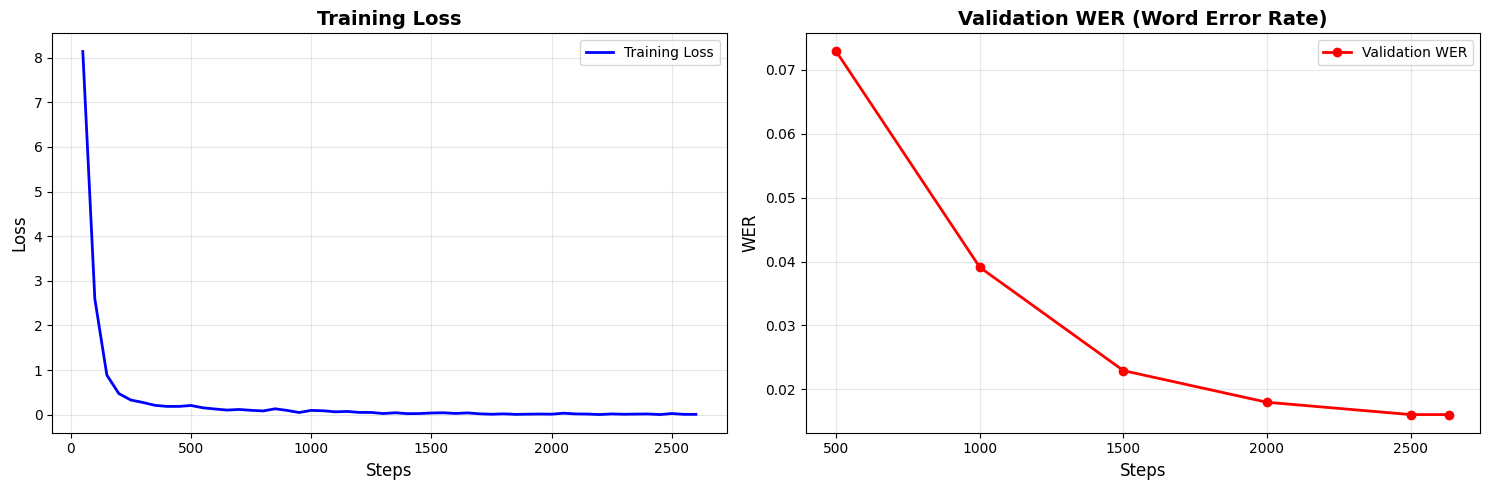

✅ 訓練曲線已儲存: training_curves.png

📊 最終結果:
   最低訓練 Loss: 0.0051
   最低驗證 WER: 0.0160


In [ ]:
# 📈 視覺化訓練過程
import matplotlib.pyplot as plt
import json
import os

# 讀取訓練日誌
log_history = trainer.state.log_history

# 提取訓練 loss 和驗證 WER
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_wer = [log['eval_wer'] for log in log_history if 'eval_wer' in log]
steps_loss = [log['step'] for log in log_history if 'loss' in log]
steps_eval = [log['step'] for log in log_history if 'eval_wer' in log]

# 繪圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 訓練 Loss
ax1.plot(steps_loss, train_loss, label='Training Loss', color='blue', linewidth=2)
ax1.set_xlabel('Steps', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 驗證 WER
ax2.plot(steps_eval, eval_wer, label='Validation WER', color='red', linewidth=2, marker='o')
ax2.set_xlabel('Steps', fontsize=12)
ax2.set_ylabel('WER', fontsize=12)
ax2.set_title('Validation WER (Word Error Rate)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ 訓練曲線已儲存: training_curves.png")
print(f"\n📊 最終結果:")
print(f"   最低訓練 Loss: {min(train_loss):.4f}")
print(f"   最低驗證 WER: {min(eval_wer):.4f}")